## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect vehicles on road.
* Output visual display of the detected cars.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import zipfile
from scipy.ndimage.measurements import label


from skimage.feature import hog
from skimage import data, exposure
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


In [2]:
if not os.path.isfile('data' + os.sep + 'vehicles' + os.sep + 'GTI_MiddleClose' + os.sep + 'image0003.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'vehicles.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()
if not os.path.isfile('data' + os.sep + 'non-vehicles' + os.sep + 'GTI' + os.sep + 'image1.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'non-vehicles.zip', 'r')
    zip_ref.extractall()
    zip_ref.close()

In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for (x1,y1),(x2,y2) in bboxes:
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    return draw_img # Change this line to return image copy with boxes

In [4]:
def color_hist(image, nbins=2):
    feature_image = np.copy(image)
    rhist = np.histogram(image[:,:,0], bins=nbins, range=(0, 1.0))
    ghist = np.histogram(image[:,:,1], bins=nbins, range=(0, 1.0))
    bhist = np.histogram(image[:,:,2], bins=nbins, range=(0, 1.0))
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return rhist, ghist, bhist, bin_centers, hist_features

In [5]:
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0100.png')
_, _, _, _, hist_features = color_hist(image)
#print ('image', image)
print ('hist_features', hist_features.shape, hist_features, hist_features.dtype)

hist_features (6,) [2687 1409 2613 1483 2689 1407] int64


In [6]:
def bin_spatial(img, color_space='RGB', size=(4, 4)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features


In [7]:
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0100.png')
b = bin_spatial(image)
print ('b', b.shape, b)

b (48,) [0.16078432 0.21176471 0.20588236 0.22941178 0.26372552 0.2627451
 0.19607843 0.24313727 0.24705884 0.9078432  0.8882353  0.8745098
 0.73333335 0.69411767 0.68921566 1.         1.         1.
 0.9323529  0.9901961  0.95490193 0.28627452 0.21470588 0.2
 0.61764705 0.67156863 0.6245098  0.722549   0.7137255  0.6803922
 0.4166667  0.46862745 0.4343137  0.3019608  0.3372549  0.3264706
 0.09509804 0.1254902  0.12058824 0.25       0.25980395 0.24901962
 0.2764706  0.30686277 0.2882353  0.08627451 0.10980392 0.10980392]


In [8]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    return return_list


In [9]:
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0100.png')
hog_features = get_hog_features(image, orient=9, pix_per_cell=16, cell_per_block=2, vis=False, feature_vec=True)
print ('hog_features', hog_features.shape)   

hog_features (324,)


In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, orient=9, pix_per_cell=16, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    for image in imgs:
        if isinstance(image, str):
            image = mpimg.imread(image)
        hog_features = []
        feature_image = np.copy(image)
        feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
        hog_features.append(get_hog_features(feature_image[:,:], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
        features.append(hog_features)
    return features



In [11]:
features = extract_features(['./data/vehicles/GTI_MiddleClose/image0100.png'])
print ('features', features[0].shape, features)

features (324,) [array([0.29030032, 0.14637741, 0.16167668, 0.13886553, 0.24775555,
       0.08615499, 0.09254924, 0.06025342, 0.16372523, 0.05791912,
       0.02412602, 0.01588942, 0.14087528, 0.30825717, 0.1033144 ,
       0.04116886, 0.02688365, 0.0451087 , 0.05705476, 0.08914813,
       0.10510951, 0.28983154, 0.30825717, 0.20841174, 0.30825717,
       0.17649058, 0.23881424, 0.0501651 , 0.05708067, 0.07133388,
       0.18035495, 0.30825717, 0.1645987 , 0.01565907, 0.0867569 ,
       0.07544834, 0.06665416, 0.02776457, 0.01828578, 0.16212131,
       0.38971466, 0.1188957 , 0.04737771, 0.03093809, 0.05191174,
       0.19702423, 0.11442549, 0.08950605, 0.08291347, 0.38971466,
       0.14892006, 0.08982119, 0.1450289 , 0.17150732, 0.05773072,
       0.06568925, 0.08209206, 0.20755509, 0.38971466, 0.18942256,
       0.01802069, 0.09984109, 0.08682704, 0.06206025, 0.05211853,
       0.08879504, 0.25296282, 0.38971466, 0.04216827, 0.01554263,
       0.03762106, 0.00884642, 0.14916058, 0.

In [12]:
def get_dataset(directory):
    car_filelist = []
    notcar_filelist = []
    
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if name.endswith('.png'):
                if (os.sep + 'vehicles' + os.sep ) in path:
                    car_filelist.append(path + os.sep + name)
                if (os.sep + 'non-vehicles' + os.sep ) in path:
                    notcar_filelist.append(path + os.sep + name)

    return car_filelist, notcar_filelist


In [13]:
car_filelist, notcar_filelist = get_dataset('./data')

In [14]:
X, y, mean, scale = None, None, None, None

X_train, X_test, y_train, y_test = None,  None,  None,  None

if os.path.isfile('dataset.npz'):
    print('dataset.npz exists')
    X_scaler = preprocessing.StandardScaler()
    dataset = np.load('dataset.npz')
    X, y, X_scaler.mean_ , X_scaler.scale_  = dataset['X'],  dataset['y'], dataset['mean'], dataset['scale']
else:
    print('dataset.npz new')
    car_features    = extract_features(car_filelist)
    notcar_features = extract_features(notcar_filelist)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y_car = np.ones((len(car_filelist)))
    y_notcar = np.zeros((len(notcar_filelist)))
    y = np.hstack((y_car, y_notcar)).astype(np.int)
    X_scaler = preprocessing.StandardScaler().fit(X)
    X = X_scaler.transform(X)
    np.savez_compressed('dataset.npz', X = X, y = y, mean = X_scaler.mean_, scale = X_scaler.scale_)


dataset.npz exists


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=452553)
print ('X_train.shape', X_train.shape)
print ('y_train.shape', y_train.shape)
print ('X_test.shape', X_test.shape)
print ('y_test.shape', y_test.shape)


X_train.shape (14208, 324)
y_train.shape (14208,)
X_test.shape (3552, 324)
y_test.shape (3552,)


In [16]:
model = None
if not os.path.isfile('model.pkl'):
    C_range = [0.200]
    gamma_range = [0.01]
    for C in C_range:
        for gamma in gamma_range:
            print ('C', C, 'gamma', gamma)
            model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            model.fit(X_train, y_train)
            joblib.dump(model, 'model.pkl') 
    print ('training end')
else:
    model = joblib.load('model.pkl') 

print ('score train', model.score(X_train, y_train))
y_train_pred = model.predict(X_train)
print ('confusion matrix train', confusion_matrix(y_train, y_train_pred))
print ('score test', model.score(X_test, y_test))
y_test_pred = model.predict(X_test)
print ('confusion matrix test', confusion_matrix(y_test, y_test_pred))



score train 0.9827561936936937
confusion matrix train [[7177    9]
 [ 236 6786]]
score test 0.9676238738738738
confusion matrix test [[1772   10]
 [ 105 1665]]


In [17]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image.shape (720, 1280, 3) 255
[1]


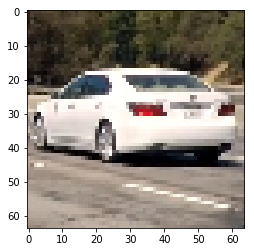

In [18]:
L = 230
S = 64
image = mpimg.imread('test_images/test1.jpg')
print ('image.shape', image.shape, np.max(image))
ii = cv2.resize(image[344:344+L,1048:1048+L], (64, 64)) 
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print (p)

[1]


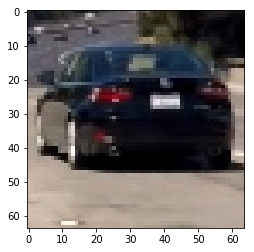

In [19]:
L = 140
S = 64
image = mpimg.imread('test_images/test1.jpg')
ii = cv2.resize(image[390:390+L,810:810+L], (S, S))   
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print (p)

[0]


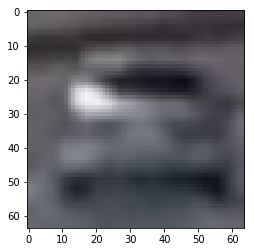

In [20]:
L = 20
S = 64
image = mpimg.imread('test_images/test1.jpg')
ii = cv2.resize(image[407:407+L,774:774+L], (S, S))   
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print (p)

In [21]:
images_features = extract_features(['data/vehicles/GTI_MiddleClose/image0100.png', 'test_images/t1.png', 'test_images/t2.png', 'test_images/t3.png', 'test_images/t4.png', 'test_images/t5.png'])
images_features = X_scaler.transform(images_features)
p = model.predict(images_features)
print(p)


[1 1 1 1 1 0]


In [22]:
L = 140
S = 64

window_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[350, 650], xy_window=(L, L), xy_overlap=(0.7, 0.7)) 
print ('len(window_list)', len(window_list))
#print ('window_list', window_list)
box_detected = []

len(window_list) 112


((798, 392), (938, 532))
((1134, 392), (1274, 532))
end 112 112


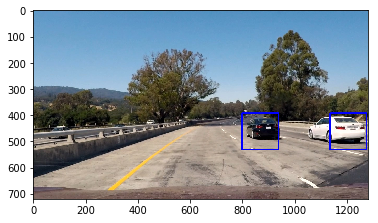

In [23]:
i = 0
j = 0

image_with_detection = np.copy(image)

for window in window_list:
    i = i + 1
#    if (window[1][0] >= 720) or (window[1][1] >= 1280):
#        continue
    ii = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (S, S))      
    ii = ii.astype(np.float32) / 255.0
    image_features = extract_features([ii])
    image_features = X_scaler.transform(image_features)
    p = model.predict(image_features)
#    print (p)
    if p[0] == 1:
        print (window)
        box_detected.append(window)
        image_with_detection =  draw_boxes(image_with_detection, bboxes=[window], color=(0, 0, 255), thick=3)
    j = j + 1
print ('end', i, j)

fig = plt.figure()
plt.imshow(image_with_detection)


In [24]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [25]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

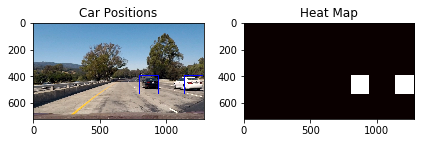

In [27]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_detected)
heat = apply_threshold(heat,0)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [28]:
N = 10
box_detected_hist = []

def pipeline(img):
#    image_with_detection = np.copy(img)
    global box_detected_hist
    S = 64
    box_detected = []
    for L in [70, 100, 130, 160, 190, 220]:
#    for L in [140]:
        window_list = slide_window(img,  x_start_stop=[0, 1280], y_start_stop=[350, 650], xy_window=(L, L), xy_overlap=(0.85, 0.85)) 
        for window in window_list:
            ii = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (S, S))      
            ii = ii.astype(np.float32) / 255.0
            image_features = extract_features([ii])
            image_features = X_scaler.transform(image_features)
            p = model.predict(image_features)
            if p[0] == 1:
#            print (window)
                box_detected.append(window)
#                image_with_detection =  draw_boxes(image_with_detection, bboxes=[window], color=(0, 0, 255), thick=3)
    box_detected_hist.insert(0, box_detected)
    if (len(box_detected_hist) > N):
        del box_detected_hist[-1]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_detected = []
    for b in box_detected_hist:
        for bb in b:
            box_detected.append(bb)
            
    heat = add_heat(heat,box_detected)
    heat = apply_threshold(heat,70)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
    return cv2.addWeighted(img, 0.8, draw_img, 1., 0.)



In [29]:
make_video = True
if make_video:
    white_output = 'output'  + os.sep + 'project_video.mp4'
    clip = VideoFileClip("project_video.mp4")
    white_clip = clip.fl_image(pipeline) 
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [5:13:16<00:14, 14.92s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

CPU times: user 5h 13min 10s, sys: 3.62 s, total: 5h 13min 14s
Wall time: 5h 13min 16s
